In [1]:
pip install git+https://github.com/gavin-s-smith/mcrforest

  Cloning https://github.com/gavin-s-smith/mcrforest to /tmp/pip-req-build-wubod489
  Running command git clone --filter=blob:none -q https://github.com/gavin-s-smith/mcrforest /tmp/pip-req-build-wubod489
  Resolved https://github.com/gavin-s-smith/mcrforest to commit 3e450eeb210bbc13e03161cf09878def13d6aa41
  Preparing metadata (setup.py) ... done
  Created wheel for mcrforest: filename=mcrforest-3.0.2-cp38-cp38-linux_x86_64.whl size=4045926 sha256=d784b3097ddc932229f9d19e2310f27a739b494e097c23de2d45033e871b0ed4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ca65uuk3/wheels/ee/af/7f/4805c047bafb01b636960ad5f1795b1c59a8afc0aad07c1c1d
Successfully built mcrforest
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mcrforest.forest import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from mcrforest.Datasets import get_demo_dataset
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.datasets import load_wine
data = load_wine()
data=pd.DataFrame(data=np.c_[data['data'],data['target']],columns=data['feature_names']+['target'])
data.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [4]:
from sklearn import  datasets
from sklearn.model_selection import train_test_split

#-- Define you training input and output
y = data["target"]
X = data.loc[:, ~data.columns.isin(['target'])]

# Split off a held-out test set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=42, shuffle = True, stratify=y)

In [35]:
%%time
from sklearn.model_selection import KFold, GridSearchCV
from mcrforest.forest import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mcrforest.forest import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from mcrforest.Datasets import get_demo_dataset

redo_cv = False
if redo_cv:
    # For the model class RF
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    # For the model class RF
    search = {'n_estimators':[10],'min_impurity_decrease':[0.0001,0.001,0.01],'max_features':[1,'auto'],'max_depth': [3,5]}
    rf_cv_model = GridSearchCV(RandomForestClassifier(bootstrap=False, random_state = 13111985), search, cv = kf, refit = True, verbose = 10)
    rf_best_model = rf_cv_model.fit(X_train, y_train.values.flatten()).best_estimator_
    print(rf_best_model.get_params())
else:
    best_params = {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'max_leaf_nodes': None, 
                   'max_samples': None, 'mcr_tree_equivilient_tol': 1e-05, 'min_impurity_decrease': 0.01, 'min_impurity_split': None, 'min_samples_leaf': 1, 
                   'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'performance_equivilence': True, 
                   'random_state': 13111985, 'spoof_as_sklearn': False, 'verbose': 0, 'warm_start': False}    
    rf_best_model = RandomForestClassifier(**best_params)
    rf_best_model.fit(X_train, y_train.values.flatten())

print('RF Reference Model ACC_train: {}'.format(accuracy_score(y_train, rf_best_model.predict(X_train))))
print('RF Reference Model ACC_test: {}'.format(accuracy_score(y_test, rf_best_model.predict(X_test))))
print('RF best model params: ',rf_best_model)


RF Reference Model ACC_train: 1.0
RF Reference Model ACC_test: 0.9662921348314607
RF best model params:  RandomForestClassifier(max_features=3, min_impurity_decrease=0.01,
                       n_estimators=10, random_state=13111985)
CPU times: user 63.3 ms, sys: 209 µs, total: 63.5 ms
Wall time: 61.5 ms


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mcr(df_in):
    df_in = df_in.copy()
    df_in.columns = [ x.replace('MCR+', 'MCR- (lollypops) | MCR+ (bars)') for x in df_in.columns]
    ax = sns.barplot(x='MCR- (lollypops) | MCR+ (bars)',y='variable',data=df_in)

    plt.hlines(y=range(df_in.shape[0]), xmin=0, xmax=df_in['MCR-'], color='skyblue')
    plt.plot(df_in['MCR-'], range(df_in.shape[0]), "o", color = 'skyblue')

In [37]:
%%time
import mcrforest
from tqdm import tqdm
variables = []
mcrp = []
mcrm = []
i = 0
for c in tqdm(X_train.columns):
    variables.append(c)
    mcr_p = rf_best_model.mcr( X_train.values,y_train.values.flatten(), np.asarray([i]), 
                        num_times = 100, debug = False, mcr_type = 1, mcr_as_ratio=False)

    mcr_m = rf_best_model.mcr( X_train.values,y_train.values.flatten(), np.asarray([i]), 
                        num_times = 100, debug = False, mcr_type = -1, mcr_as_ratio=False)

    mcrm.append(mcr_m)
    mcrp.append(mcr_p)
    i += 1

rf_results = pd.DataFrame({'variable':variables, 'MCR+':mcrp, 'MCR-':mcrm})

100%|██████████| 13/13 [00:01<00:00, 11.37it/s]

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.15 s


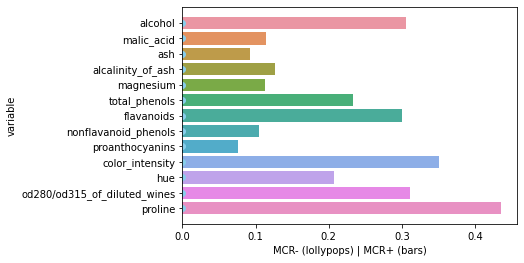

In [38]:
plot_mcr(rf_results)

Text(0.5, 0, 'Decrease in impurity score')

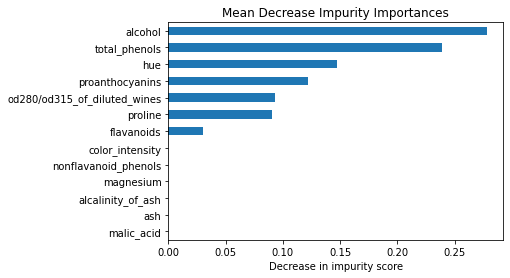

In [39]:
feature_names = list(X.columns.values)

mdi_importances = pd.Series(
    rf_best_model[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)
mdi_importances

ax = mdi_importances.plot.barh()
ax.set_title("Mean Decrease Impurity Importances")
ax.set_xlabel("Decrease in impurity score")

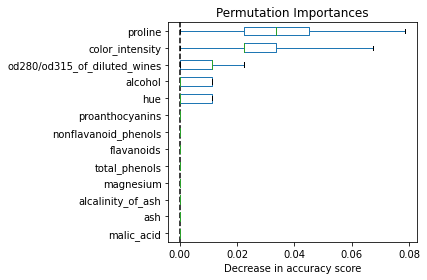

In [40]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_best_model, X_train, y_train, n_repeats=100, random_state=42, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Text(0.5, 0, 'Decrease in accuracy score')

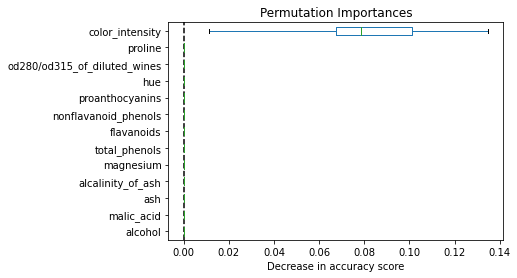

In [ ]:
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")